#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 16 13:25:39 2021
Script running several configurations of dMAPS

Adapted to run on NIOZ cluster

@author: ccamargo
"""


In [1]:
import sys
sys.path.append("/export/lv1/user/ccamargo/py_scripts/")
# import utils_SL as sl 
import utils_dMAPS as dmaps
import xarray as xr
import numpy as np
import os
import time

In [2]:
initial_time=time.time()

In [3]:
# settings
path_pydmaps = '/export/lv1/user/ccamargo/py-dMaps/'
path_dmaps = '/export/lv1/user/ccamargo/reg/world_1deg/'
input_file = 'MSLA_CMEMS_glb_merged_1993-2019_detrend_deseason_300kmfilter_res1deg.nc'
res=0.25
t0=1993
t1=2019
upper_lat = 45.98
lower_lat = 30.18
left_lon  =  -6
right_lon = 36.3
coordbox=[left_lon,right_lon,lower_lat,upper_lat]

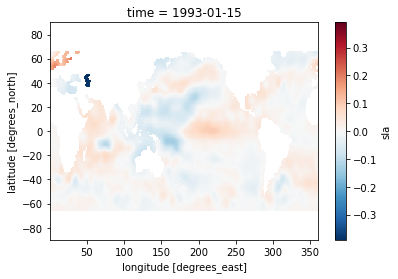

In [9]:
# select ± 66 degree lat
ds=xr.open_dataset(path_dmaps+input_file)

input_file_dmaps = 'MSLA_CMEMS_glb_merged_1993-2019_detrend_deseason_300kmfilter_res1deg_66lat.nc'
ds = ds.where((ds.lat>-66) & (ds.lat<66),np.nan)
ds.sla[0,:,:].plot()
ds.to_netcdf(path_dmaps+input_file_dmaps)

<xarray.DataArray 'lon' ()>
array(1.)


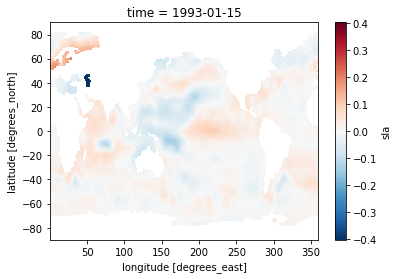

In [5]:
# get dimensions


print(ds.lon[1]-ds.lon[0])
lat_name = np.array(ds.coords)[2]
lon_name = np.array(ds.coords)[1]



In [ ]:
#% % Run dmaps for several k values

delta = 10000
alpha=0.01
tau_max = 12
q = 0.05
for k in np.arange(4,25):
    start_time=time.time()
    print('k = {}'.format(k))
    
    print('Making output directory')
    outpath=path_dmaps+'k{}/'.format(k)
    if not os.path.exists(outpath):
            os.makedirs(outpath)
    config_name = 'world_k{}'.format(k)
    print('Creating configuration file')
    dmaps.create_config_file(path_to_config=path_dmaps,
                             config_name=config_name,
                                path_to_file=path_dmaps+input_file_dmaps,
                                output_dir=outpath,
                                var_name='sla',
                                lat_name=lat_name,
                                lon_name=lon_name,
                                delta_samples=delta,
                                alpha=alpha,
                                k=k,
                                tau_max=tau_max,
                                q=q
                                )

    #% % run dmaps
    print('Running deltaMAPS')
    dmaps.run_dMaps(config_file_name=path_dmaps+config_name+'.json',
                   path_to_dmaps=path_pydmaps)
    
    #% % check if we have results:
    print('Checking output')
    d_list = dmaps.get_filelist(outpath+'domain_identification/','.npy')
    n_list = dmaps.get_filelist(outpath+'network_inference/','.npy')
    s_list = dmaps.get_filelist(outpath+'seed_identification/','.npy')
    if len(d_list)>0:
        print('Domains identification successful')
        if len(n_list)>0:
            print('Network inference successful')
            output = 'all'
        else:
            output = 'domain'
        if len(s_list)>0:
            show_seeds='homogeneity'
        else:
            show_seeds=False
        
        # make directory to save plots:
        if not os.path.exists(outpath+'plot'):
            os.makedirs(outpath+'plot')        
        
        #% % plot results
#        print('Plotting output')
#        dmaps.plot_dMaps_output(geofile = path_dmaps+input_file_dmaps,
#                          fpath = outpath, 
#                          output = output, 
#                          outpath = outpath+'plot/',
#                          extent= [left_lon,right_lon,lower_lat,upper_lat],
#                          show_seeds = show_seeds)
    else:
        print('No results for k = {}'.format(k))
    print('Elapsed time: {}'.format(time.time()-start_time))


